In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
import sksurv as sks
from sksurv.nonparametric import kaplan_meier_estimator#
warnings.filterwarnings("ignore")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/agatheguilloux/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.

AttributeError: _ARRAY_API not found

In [2]:
dataset_name = "AIDS_Clinical_Trials_Group"
data_file= "dataset/" + dataset_name + "/HIV_control.csv"
feat_types_file = "dataset/" + dataset_name + "/data_types.csv"
miss_file = "dataset/" + dataset_name + "/Missings.csv"
true_miss_file = None

In [3]:
HIV_control = pd.read_csv(data_file)

### Data loading and Feature analysis

In [4]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)

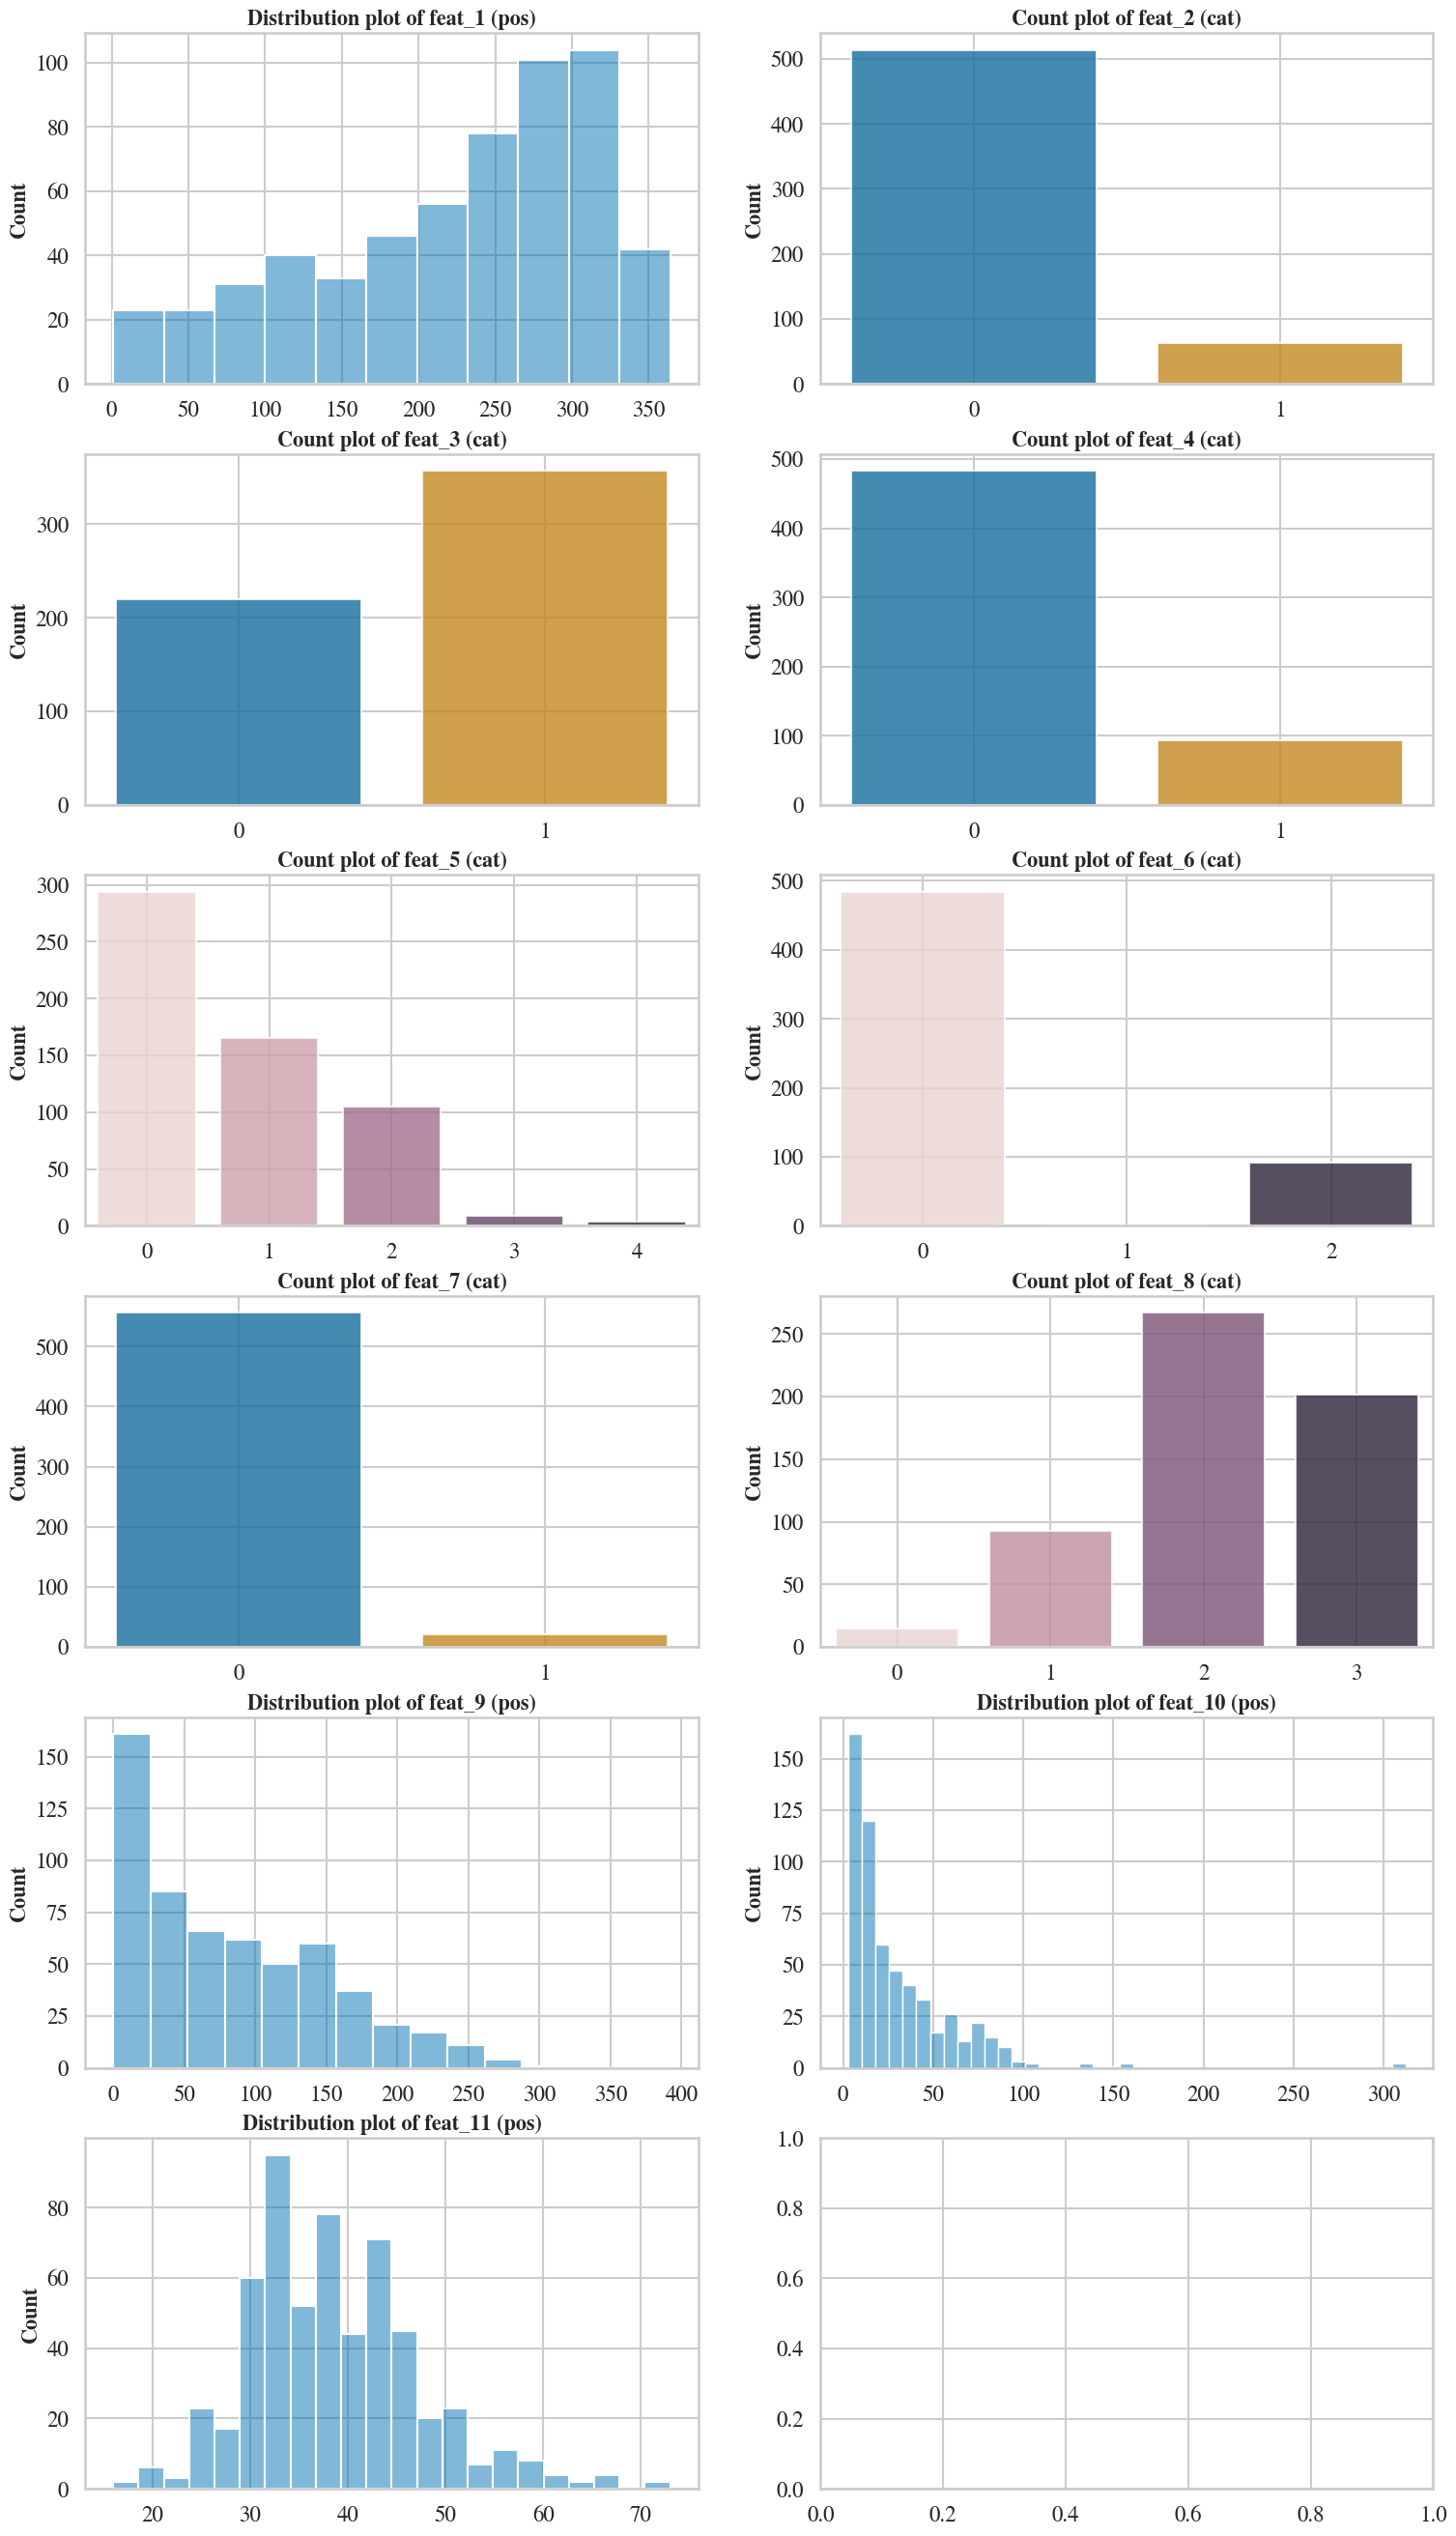

In [5]:
# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])
visualization.plot_data(features_df, feat_types_dict)

### Experiment setting

In [6]:
prop_keep =0.2
rng = np.random.default_rng()
select = rng.binomial(1,prop_keep,data.shape[0])
data_keep = data[select==1]
miss_mask_keep = miss_mask[select==1]
true_miss_mask_keep = true_miss_mask[select==1]

In [7]:
train_test_share = .99
n_samples = data_keep.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
print(len(train_index))
test_index = [i for i in np.arange(n_samples) if i not in train_index]

111


In [8]:
# Train-test split
data_keep_train = data_keep[train_index]
miss_mask_keep_train = miss_mask_keep[train_index]
true_miss_mask_keep_train = true_miss_mask_keep[train_index]

data_keep_test = data_keep[test_index]
miss_mask_keep_test = miss_mask_keep[test_index]
true_miss_mask_keep_test = true_miss_mask_keep[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_keep_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_keep_train, true_miss_mask_keep_train)

# test set
n_test_samples = data_keep_test.shape[0]

# Number of batches
n_batches_test = 1

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_keep_test, true_miss_mask_keep_test)

# Back to original values
data_train_transformed = data_processing.discrete_variables_transformation(data_keep_train, 
                                                                           feat_types_dict)
data_test_transformed = data_processing.discrete_variables_transformation(data_keep_test, 
                                                                           feat_types_dict)

### Model loading

In [9]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 10
dim_latent_y = 5
dim_latent_s = 5
epochs = 1000
lr = 1e-3
save_file= "{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name,  dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_keep_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [10]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
error_observed_test , error_missing_test = [], []

for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = np.random.permutation(data_keep_train.shape[0])
    data_keep_train = data_keep_train[perm]
    miss_mask_train = miss_mask_keep_train[perm]
    true_miss_mask_keep_train = true_miss_mask_keep_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_keep_train, 
                                                          feat_types_dict, miss_mask_keep_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train

        # Save the generated samples and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
 

    # #Transform discrete variables back to the original values
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train, 
                                                                                   feat_types_dict)
    est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed[:n_train_samples], 
                                                            miss_mask_train[:n_train_samples], 
                                                            feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed[:n_train_samples], 
                                                                                est_data_train_transformed[:n_train_samples],
                                                                                feat_types_dict, 
                                                                                miss_mask_keep_train[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))

    #visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)
    
    # Test set
    with torch.no_grad(): 
        samples_list = []
        for i in range(n_batches_test):
            data_list, miss_list = data_processing.next_batch(data_keep_test, feat_types_dict, 
                                                              miss_mask_keep_test, n_test_samples, i)

            # Mask unknown data (set unobserved values to zero)
            data_list_observed = [data * miss_list[:, i].view(n_test_samples, 1) for i, data in enumerate(data_list)]

            vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3)
            samples_list.append(vae_res["samples"])
    
            #Concatenate samples in arrays
            #est_data_test = statistic.samples_concatenation(samples_list)
            #est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, 
            #                                                                              feat_types_dict)
            est_data_test = statistic.samples_concatenation(samples_list)[-1]
            est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, feat_types_dict)
    
    error_observed_samples_test, error_missing_samples_test = statistic.error_computation(data_test_transformed, 
                                                                                est_data_test_transformed, 
                                                                                feat_types_dict, 
                                                                                miss_mask_keep_test)
    error_observed_test.append(torch.mean(error_observed_samples_test))
    error_missing_test.append(torch.mean(error_missing_samples_test))


    print("Training finished.")

torch.save(vae_model.state_dict(), network_file)


#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training fin

Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training fin

Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training fin

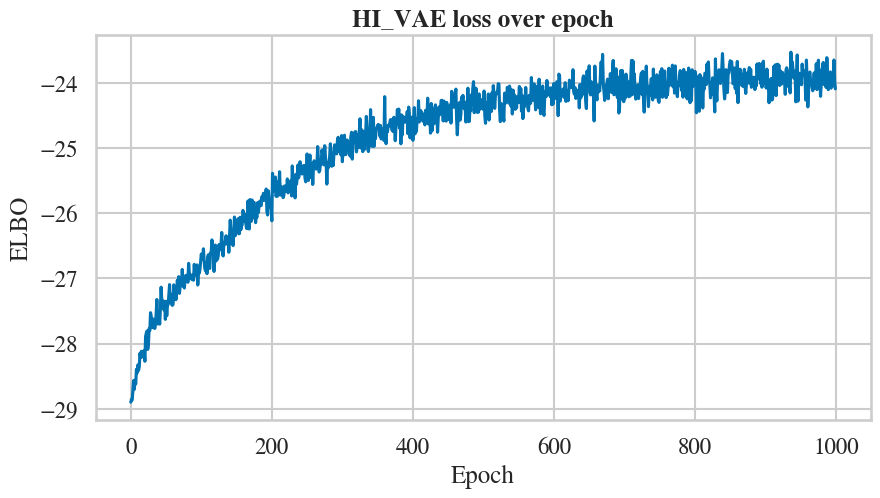

In [11]:
visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")


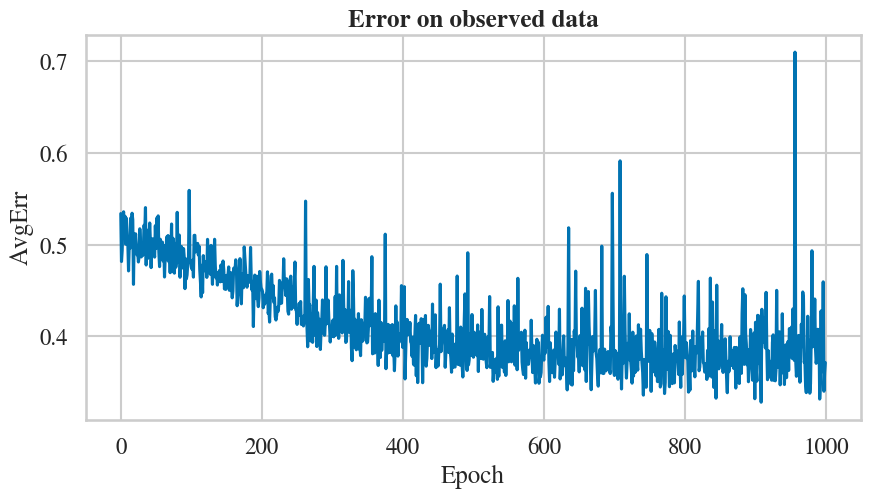

In [12]:
visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
                                xlabel = "Epoch", ylabel = "AvgErr")


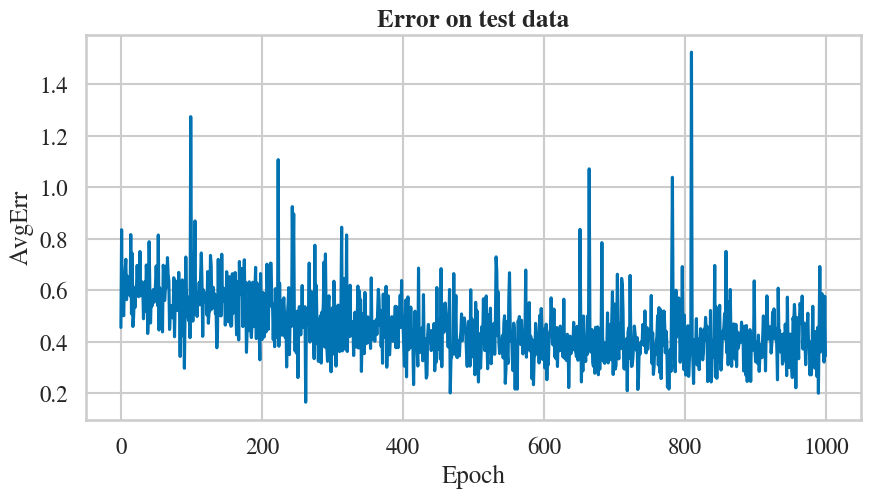

In [13]:
visualization.plot_loss_evolution(np.array(error_observed_test), title = "Error on test data",
                                xlabel = "Epoch", ylabel = "AvgErr")

# Data Generation

In [14]:
data_keep_train.shape

torch.Size([111, 24])

In [25]:
n_samples_generation = 1000# HIV_control.shape[0] - data_keep_train.shape[0]
gen_index = np.random.choice( data_keep_train.shape[0], n_samples_generation , replace=True)

In [26]:
data_gen = data_keep_train[gen_index]

In [27]:
miss_mask_keep_gen = miss_mask_keep_train[gen_index]
miss_mask_keep_gen.shape

torch.Size([1000, 11])

In [28]:
with torch.no_grad(): 

    data_list, miss_list = data_processing.next_batch(data_gen, feat_types_dict, 
                                                      miss_mask_keep_gen, n_samples_generation, 0)

    # Mask unknown data (set unobserved values to zero)
    data_list_observed = [data * miss_list[:, i].view(n_samples_generation, 1) for i, data in enumerate(data_list)]

    vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3)
    samples_list.append(vae_res["samples"])

    #Concatenate samples in arrays
    #est_data_test = statistic.samples_concatenation(samples_list)
    #est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, 
    #                                                                              feat_types_dict)
    est_data_test = statistic.samples_concatenation(samples_list)[-1]
    est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, feat_types_dict)


In [29]:
est_data_test_transformed.shape

torch.Size([1467, 11])

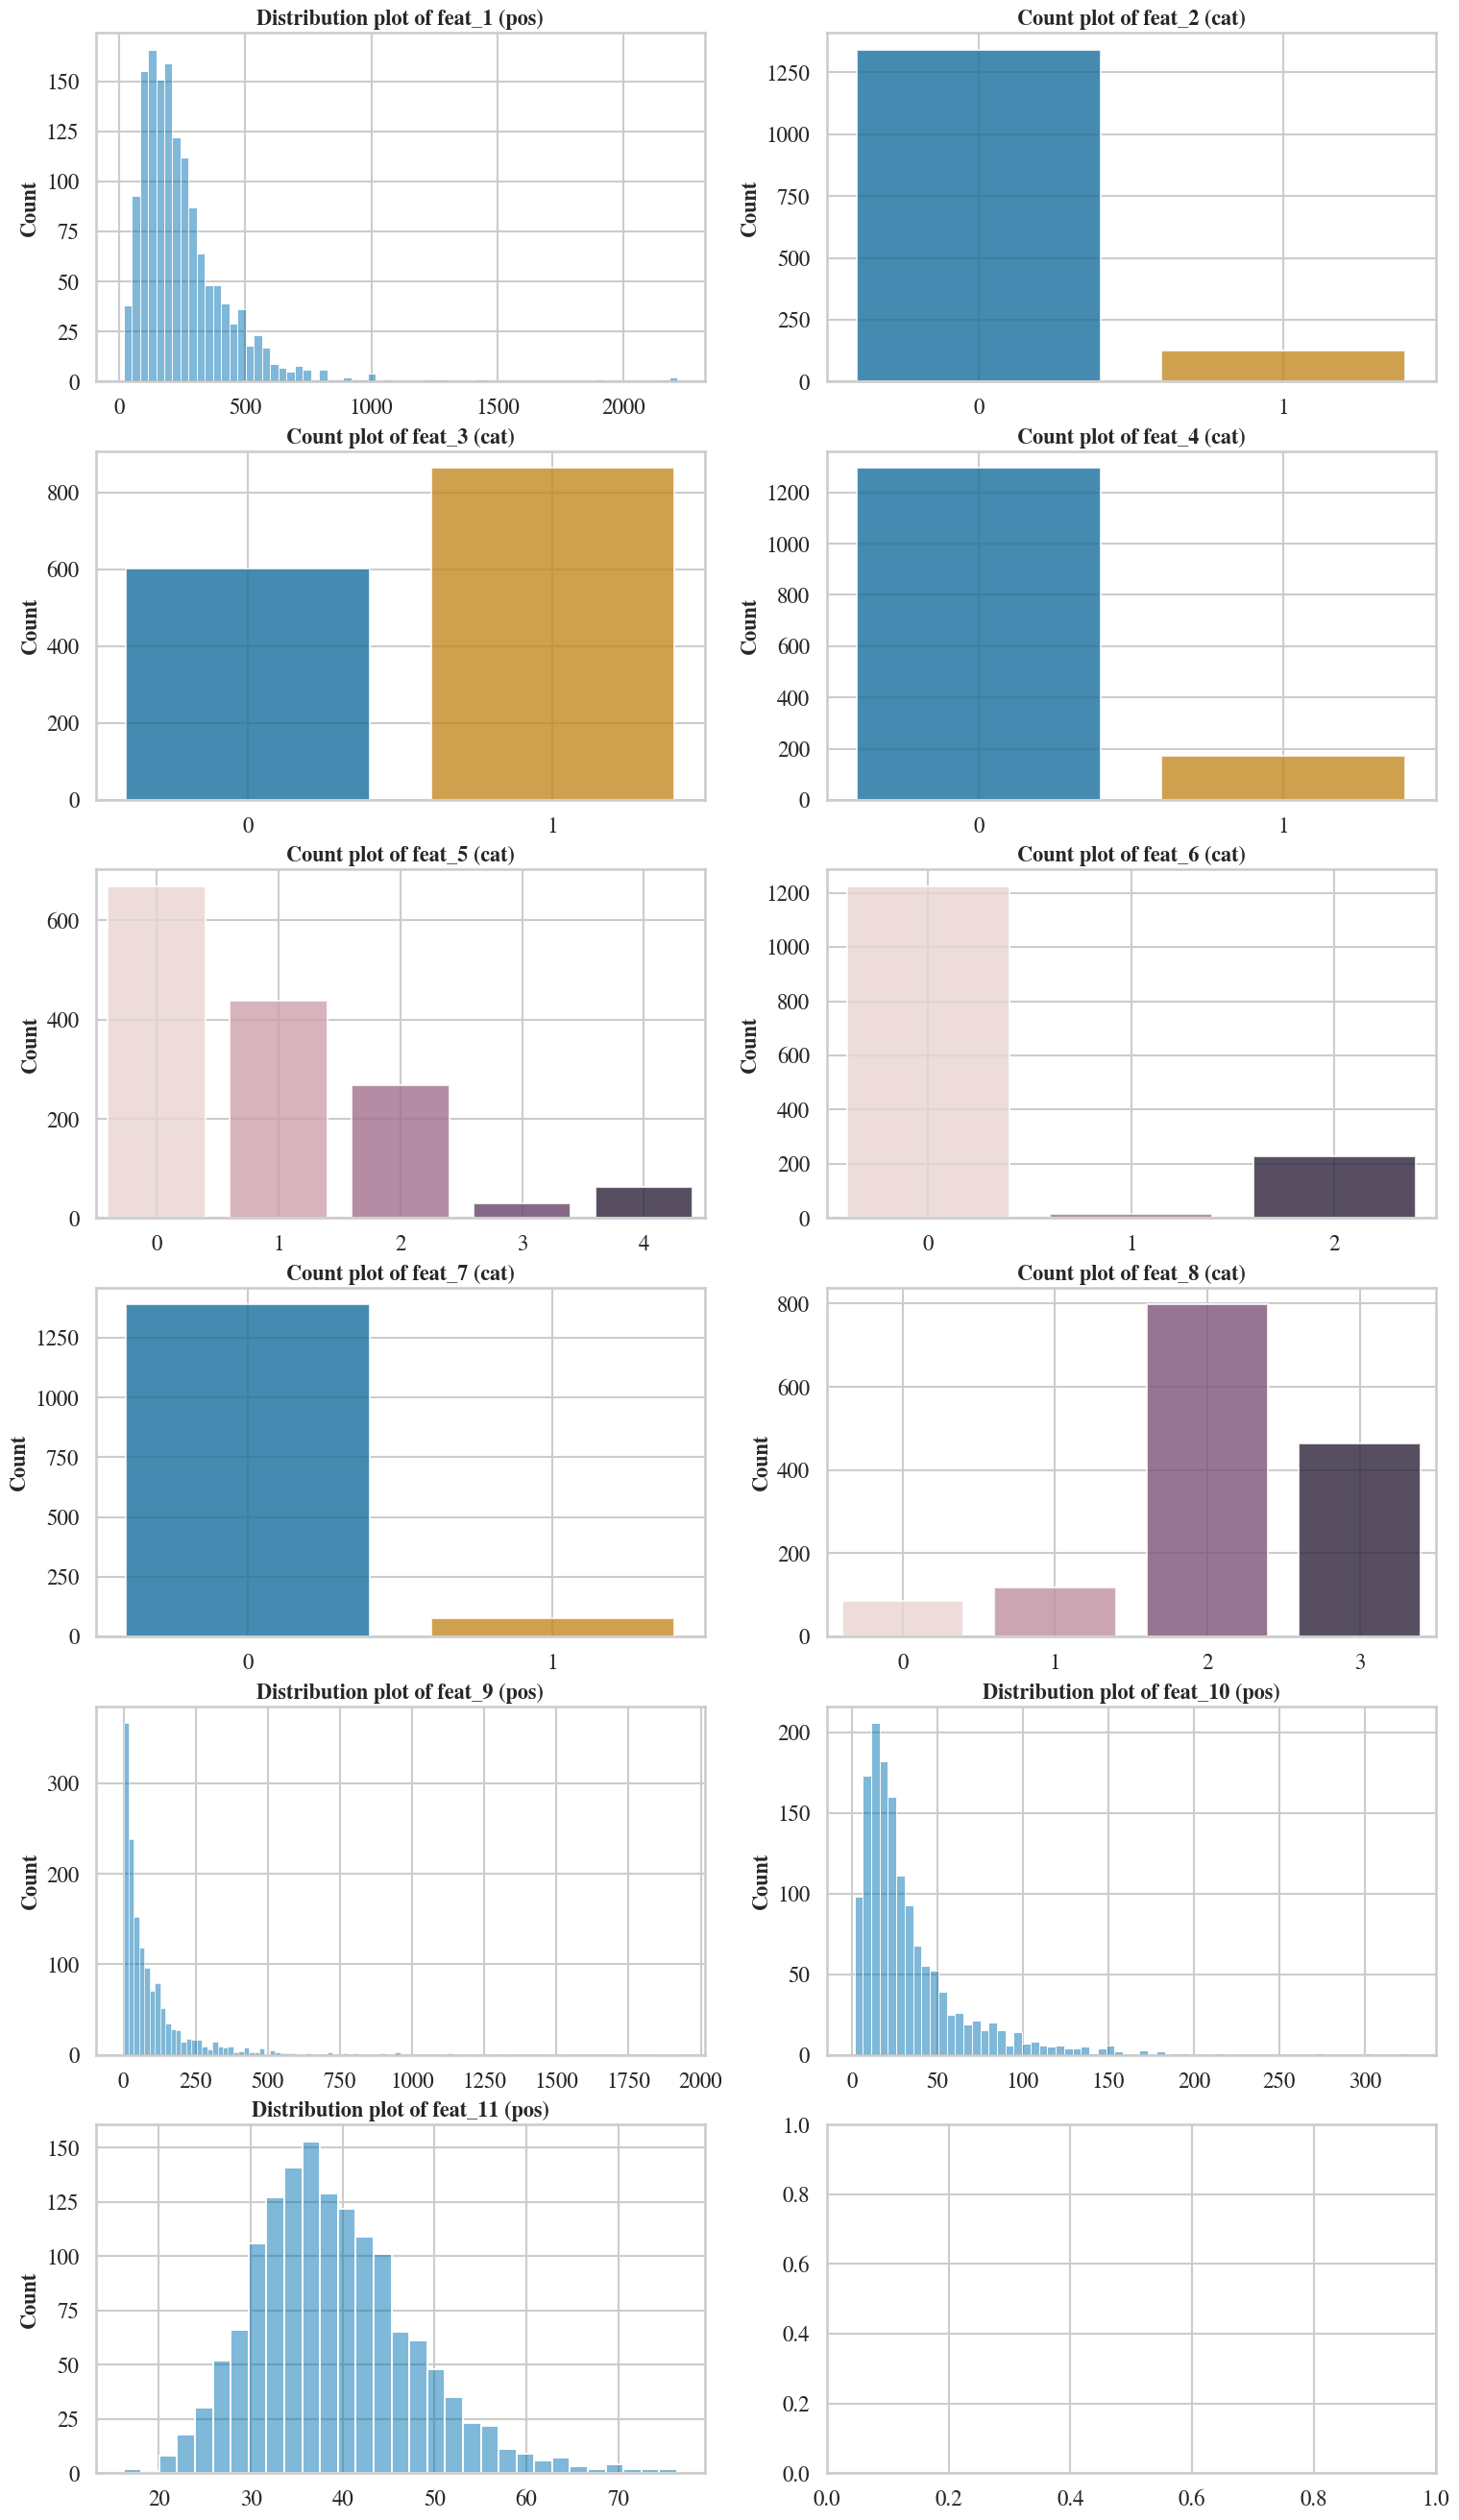

In [36]:
# Feature analysis
features_df = pd.DataFrame(est_data_test_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])
visualization.plot_data(features_df, feat_types_dict)

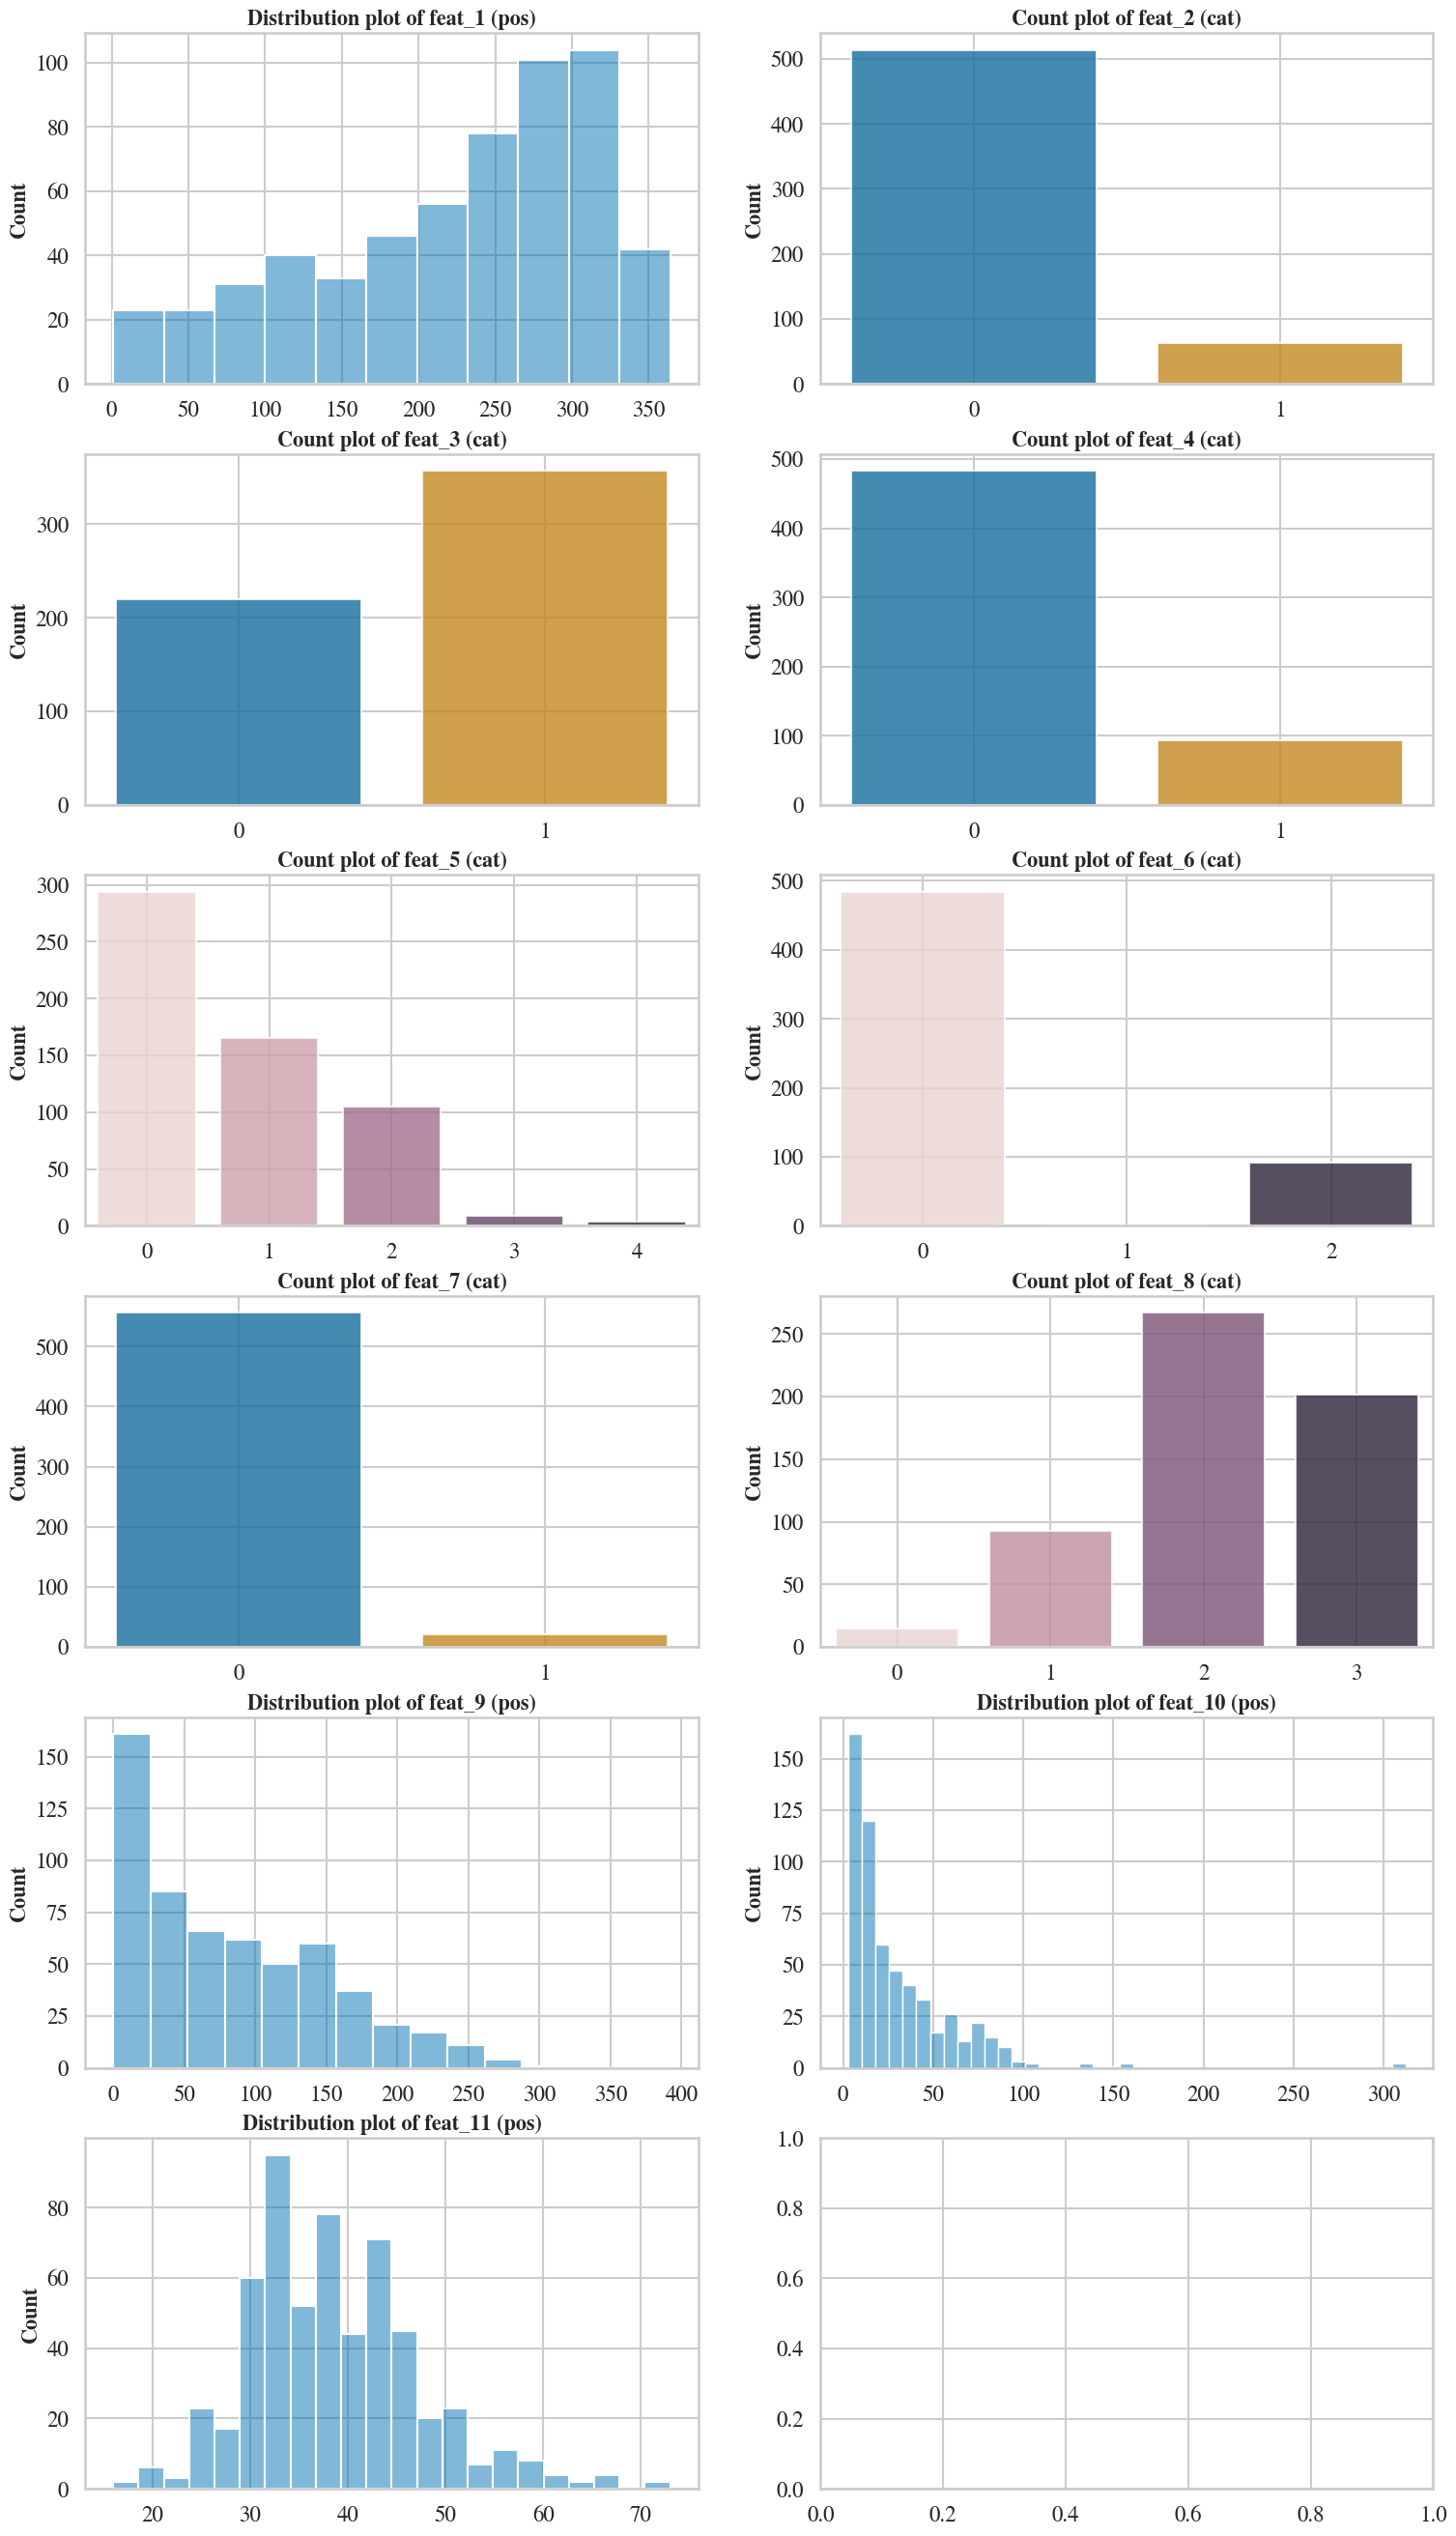

In [31]:
# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])
visualization.plot_data(features_df, feat_types_dict)

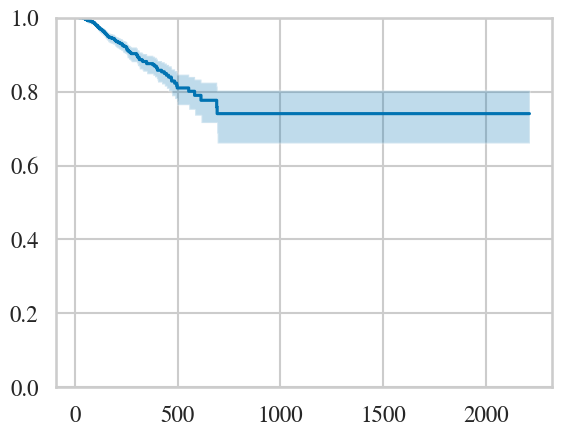

In [32]:
delta = np.array(est_data_test_transformed[:,1] , dtype=bool)
time = est_data_test_transformed[:,0]
x, y, conf_int = kaplan_meier_estimator(delta,time,
                                        conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.show()

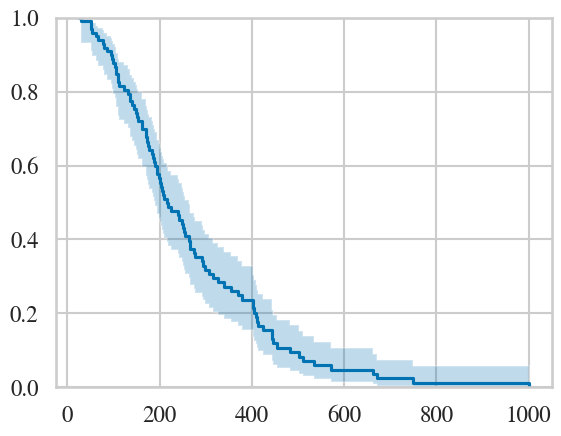

In [33]:
delta = np.array(est_data_train[:,1] , dtype=bool)
time = est_data_train[:,0]
x, y, conf_int = kaplan_meier_estimator(delta,time,
                                        conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.show()